# Online Retail

Dans ce mini projet, on a un ensemble de données avec plusieurs transactions s'étalant de 2010 à 2011, dans plusieurs pays et plusieurs factures et produits.

## Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

## Les données

Dans un premier temps, on va prendre connaissance des données c'est-à-dire des différents transactions. 

In [2]:
# Stockage des données brutes dans df

df = pd.read_excel('OnlineRetail.xlsx')

In [3]:
# Copie des données dans data pour pouvoir les manipuler directement

data = df.copy()

In [4]:
# Visualisation des données

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Les transactions sont renseignées selon plusieurs informations. Les features sont les suivantes,
- InvoiceNo : Numéro de la facture
- StockCode : Code de stock
- Description : Description du produit
- Quantity : Quantité
- InvoiceDate : Date de facturation
- UnitPrice : Prix de l'unité
- CustumerID : Identifiant du client
- Country : Pays

Ainsi, on va analyser une par une ces features.

### Les pays

In [6]:
data['Country'].unique()
#np.unique(data['Country'])

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [7]:
len(data['Country'].unique())

38

Les transactions vont de l'Australie au Canade, du Singapour au Brésil, de l'Arabie Saoudite à l'Islande. Au total, il y a 38 pays dont la communité européenne. En outre, il y a des transactions où le pays est non-spécifié.

### Les factures

In [8]:
#data['InvoiceNo'].unique()
np.unique(np.array(data['InvoiceNo'], dtype='<U21'))

array(['536365', '536366', '536367', ..., 'C581499', 'C581568', 'C581569'],
      dtype='<U21')

In [9]:
len(data['InvoiceNo'].unique())

25900

In [10]:
np.where(data.groupby("InvoiceNo")["CustomerID"].nunique()>1)

(array([], dtype=int64),)

Dans la ligne ci-dessus, on cherche à savoir si une facture est bien destinée à qu'un seul client. Ainsi, l'instruction data.groupby("InvoiceNo")["CustomerID"].nunique() nous indique le nombre de client (ou du moins, le nombre d'identifiant) pour chaque numéro de facture. Par la suite, on voit qu'aucune facture n'a plus d'un client.

In [11]:
data[data['InvoiceNo']=='C581569']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


Au total, il y a 25900 factures. Parmis les factures, il y en a qui ont des quantités négatives. Cela veut dire qu'il y a des remboursements.

### Les quantités

In [12]:
data["Quantity"].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Le résultat précédent est confirmé par les quantités ci-dessus. On voit que le minimum est à peu près de -81K qui correspond sûrement aux remboursements. Sur toutes les transactions, environ 10 produits sont vendus en moyenne. De plus, la moitié des transactions correspond à une quantité de produits vendus supérieur à 3.

### Stock Code

In [13]:
data.groupby("StockCode")["Description"].nunique()

StockCode
10002           1
10080           2
10120           1
10125           1
10133           2
               ..
gift_0001_20    2
gift_0001_30    1
gift_0001_40    1
gift_0001_50    1
m               1
Name: Description, Length: 4070, dtype: int64

Dans la section au-dessus, on voit qu'un code peut-être associé à plusieurs produits. Ainsi, on va regarder en détails les codes pour lesquels on a plusieurs produits.

In [14]:
for stockcode in data['StockCode'].unique():
    if len(data[data['StockCode']==stockcode]['Description'].unique())>1:
        print(data[data['StockCode']==stockcode]['Description'].unique())

['WHITE HANGING HEART T-LIGHT HOLDER' '?' 'wrongly marked carton 22804'
 'CREAM HANGING HEART T-LIGHT HOLDER']
['WHITE METAL LANTERN' 'WHITE MOROCCAN METAL LANTERN']
['CREAM CUPID HEARTS COAT HANGER' 'incorrectly made-thrown away.' '?' nan]
['KNITTED UNION FLAG HOT WATER BOTTLE' nan]
['RED WOOLLY HOTTIE WHITE HEART.' nan]
['HAND WARMER UNION JACK' nan]
['HAND WARMER RED POLKA DOT' 'HAND WARMER RED RETROSPOT' nan]
['ASSORTED COLOUR BIRD ORNAMENT' 'damaged']
['BOX OF 6 ASSORTED COLOUR TEASPOONS' 'check']
['RECIPE BOX WITH METAL HEART' nan]
['ALARM CLOCK BAKELIKE GREEN' nan]
['INFLATABLE POLITICAL GLOBE ' nan]
[' SET 2 TEA TOWELS I LOVE LONDON ' 'SET 2 TEA TOWELS I LOVE LONDON ']
['POSTAGE' nan]
['RETRO COFFEE MUGS ASSORTED' 'sold as set/6 by dotcom' 'damages/dotcom?'
 nan]
['VINTAGE BILLBOARD DRINK ME MUG' 'check' nan]
['WOOD 2 DRAWER CABINET WHITE FINISH' nan 'crushed']
['WOOD S/3 CABINET ANT WHITE FINISH' '3 DRAWER ANTIQUE WHITE WOOD CABINET']
['WOODEN FRAME ANTIQUE WHITE ' 'cracked' n

["POTTING SHED SOW 'N' GROW SET" nan]
['PINK HEARTS PAPER GARLAND' nan]
['POTTING SHED SEED ENVELOPES' nan]
['POLYESTER FILLER PAD 45x45cm' 'Dotcom sales']
['CARD DOLLY GIRL ' nan]
['RAINY LADIES BIRTHDAY CARD' nan]
['RED WHITE SCARF  HOT WATER BOTTLE' nan]
['LANTERN CREAM GAZEBO ' 'damages' nan]
['CLASSIC FRENCH STYLE BASKET NATURAL' 'adjustment']
['CARD HOLDER GINGHAM HEART' nan]
['PINK HEART DOTS HOT WATER BOTTLE' nan]
['METAL MERRY CHRISTMAS WREATH' 'missing?']
['WHITE CHRISTMAS GARLAND STARS TREES' nan 'check' 'dotcom']
['RETROSPOT RED WASHING UP GLOVES' 'Found']
['SMALL LICORICE DES PINK BOWL' nan]
['PICNIC BASKET WICKER LARGE' 'reverse 21/5/10 adjustment' nan
 'incorrectly put back into stock' 'Found']
['CREAM SWEETHEART EGG HOLDER' nan]
['PINK 3 PIECE POLKADOT CUTLERY SET' 'CHILDRENS CUTLERY POLKADOT PINK']
['RIDGED GLASS STORAGE JAR CREAM LID' nan]
['SWEETHEART CAKESTAND 3 TIER' 'CAKESTAND, 3 TIER, LOVEHEART'
 'SWEETHEART 3 TIER CAKE STAND ']
['CHRISTMAS HANGING STAR WITH BELL

['BIRTHDAY PARTY CORDON BARRIER TAPE' 'BIRTHDAY BANNER TAPE']
['CAMOUFLAGE DESIGN TEDDY' 'check']
['BLUE SPOT CERAMIC DRAWER KNOB' nan]
['BEACH HUT KEY CABINET' nan]
['SILVER CHRISTMAS TREE BAUBLE STAND ' 'Damages/samples']
['SWEETHEART RECIPE BOOK STAND' nan]
['ART LIGHTS,FUNK MONKEY' nan]
['PLEASE ONE PERSON METAL SIGN' 'on cargo order' 'adjustment' 'check' nan
 'dotcom']
['GLITTER CHRISTMAS HEART ' 'GLITTER HEART DECORATION' 'check']
['NEWSPAPER STAND' nan]
['CINAMMON & ORANGE WREATH' 'damaged']
['WOODEN TREE CHRISTMAS SCANDINAVIAN' 'dotcom' nan]
['ROCKING HORSE GREEN CHRISTMAS ' '??']
['SWALLOW WOODEN CHRISTMAS DECORATION' 'check']
['GLITTER CHRISTMAS TREE' nan 'check']
['CHRISTMAS GARLAND STARS,TREES' nan]
['SWISS CHALET TREE DECORATION ' 'check']
['BIRD BOX CHRISTMAS TREE DECORATION' 'damaged']
['WOODEN ADVENT CALENDAR CREAM' 'check']
['WOOD AND GLASS MEDICINE CABINET' 'damaged']
['MA CAMPAGNE CUTLERY BOX' 'damages?' nan]
['WICKER WREATH LARGE' nan]
['SMALL FOLKART STAR CHRISTMAS

['RED POLKADOT PUDDING BOWL' nan]
['BLUE POLKADOT PUDDING BOWL' nan]
['JARDIN ETCHED GLASS BUTTER DISH' 'JARDIN ETCHED GLASS CHEESE DISH' nan]
['WOODLAND DESIGN  COTTON TOTE BAG' '?' nan 'found']
['TOAST ITS - DINOSAUR' nan]
['BLUE POLKADOT COFFEE MUG' nan]
['FUNKY WASHING UP GLOVES ASSORTED' 'check']
['FLOWER BURST SILVER RING CRYSTAL' nan]
['CHRISTMAS CARD SINGING ANGEL' nan]
['BLUE/CREAM STRIPE CUSHION COVER ' nan]
['VINTAGE RED KITCHEN CABINET' 'damages/showroom etc']
['LARGE CAKE STAND HANGING HEARTS' nan 'damaged']
['TUB 24 PINK FLOWER PEGS' nan]
['SET/6 BEAD COASTERS GAUZE BAG GOLD' nan]
['GROW YOUR OWN HERBS SET OF 3' nan]
['WHITE CHRISTMAS STAR DECORATION' nan]
['DOORMAT MERRY CHRISTMAS RED ' 'had been put aside' nan]
['CARDHOLDER GINGHAM CHRISTMAS TREE' nan]
['3 HEARTS HANGING DECORATION RUSTIC' nan]
['MOROCCAN TEA GLASS' nan]
['LUSH GREENS RIBBONS' nan 'Amazon']
['FROG CANDLE' nan]
['LOVE LARGE WOOD LETTERS ' nan]
['METAL SIGN NEIGHBOURHOOD WITCH ' nan]
['CHILDRENS GARDEN GL

['CUBIC MUG FLOCK BLUE ON BROWN' 'sold as set by dotcom' nan]
['CUBIC MUG PINK POLKADOT' 'Damaged']
['VINTAGE KEEPSAKE BOX TRAVELOGUE' nan]
['SET OF 36 MUSHROOM PAPER DOILIES' nan]
['WOODEN BOX ADVENT CALENDAR ' nan]
['4 BURGUNDY WINE DINNER CANDLES' nan]
['DUSTY PINK CHRISTMAS TREE 30CM' nan]
['PINK PARTY SUNGLASSES' nan]
['POSY CANDY BAG' nan]
['SET/6 GREEN SPRING PAPER CUPS' 'damaged']
['PINK ROSE WASHBAG' nan]
['GARDENIA 1 WICK MORRIS BOXED CANDLE' nan]
['PACK 3 IRON ON DOG PATCHES' nan]
['DAISY NOTEBOOK ' nan]
['EIGHT PIECE CREEPY CRAWLIE SET' nan]
['SMOKEY GREY COLOUR D.O.F. GLASS' 'sold as set on dotcom'
 'SMOKEY GREY COLOUR GLASS']
['S/3 POT POURI CUSHIONS BLUE COLOURS' nan]
['BLACK AND WHITE DOG BOWL' 'smashed']
['ASSORTED TUTTI FRUTTI HEART BOX' 'found' 'check']
['HAND TOWEL PALE BLUE W FLOWERS' nan]
['WHITE AND BLUE CERAMIC OIL BURNER' nan]
['GREEN POP ART MAO CUSHION COVER ' nan]
['HEART SHAPED MIRROR' nan]
['PINK PAISLEY ROSE GIFT WRAP' nan]
['PSYCHEDELIC WALL THERMOMETER'

['POLYESTER FILLER PAD 30CMx30CM' 'check']
['SET/3 POT PLANT CANDLES' nan]
['RED  EGG  SPOON' nan]
['MIDNIGHT BLUE DROP CRYSTAL NECKLACE' 'stock check']
['SILVER/MOP ORBIT NECKLACE' 'check' 'SILVER M.O.P. ORBIT NECKLACE']
['ETCHED GLASS STAR TREE DECORATION' nan]
['CLASSIC FRENCH STYLE BASKET BROWN' 'check']
['CREAM DELPHINIUM ARTIFICIAL FLOWER' 'wet damaged']
['LARGE WHITE/PINK ROSE ART FLOWER' 'wet damaged' nan]
['MEDIUM WHITE/PINK ROSE ART FLOWER' nan]
['TOYBOX  WRAP ' nan]
['PINK STRAWBERRY HANDBAG ' 'check' nan]
['GREETING CARD,SQUARE, DOUGHNUTS' 'check' 'damaged']
['ACRYLIC HANGING JEWEL,BLUE' nan 'check']
['METAL SIGN,CUPCAKE SINGLE HOOK' 'Amazon']
['YELLOW DRAGONFLY HELICOPTER' nan]
['CHEST NATURAL WOOD 20 DRAWERS' 'test']
['CAMOUFLAGE DOG COLLAR' nan]
['BLACK FLOWER CANDLE PLATE' nan]
['POPART WOODEN PENCILS ASST' nan 'check']
['TEATIME FUNKY FLOWER BACKPACK FOR 2' nan]
['RED POLKADOT BEAKER ' 'damages' nan]
['ACRYLIC GEOMETRIC LAMP' 'samples/damages']
['PINK CAT FLORAL CUSHIO

['SMALL DECO JEWELLERY STAND' 'SMALL JEWELLERY STAND' nan]
['ALUMINIUM STAMPED HEART' 'ALUMINIUM HEART']
['DOUBLE CERAMIC PARLOUR HOOK' 'PARLOUR CERAMIC WALL HOOK']
['VINTAGE EMBOSSED HEART' 'VINTAGE ENGRAVED HEART']
['GOLD WINE GOBLET' nan]
['GOLD APERITIF GLASS' 'damages']
['IVORY CHANDELIER T-LIGHT HOLDER' 'rusty thrown away']
['FLOWERS CHANDELIER T-LIGHT HOLDER' 'CRYSTAL CHANDELIER T-LIGHT HOLDER'
 'rusty throw away']
['SMALL ZINC HEART WALL ORGANISER' '?' nan]
['MARIE ANTOIENETT TRINKET BOX GOLD' 'MARIE ANTOINETTE TRINKET BOX GOLD'
 'damages']
['IVORY SWEETHEART WIRE LETTER RACK ' nan]
['LARGE ZINC HEART WALL ORGANISER' nan]
['MINIATURE ANTIQUE ROSE HOOK IVORY' 'MINITURE ANTIQUE ROSE HOOK IVORY']
['ZINC T-LIGHT HOLDER STAR LARGE' 'ZINC T-LIGHT HOLDER STARS LARGE']
['TEATIME GEL PENS ASST' nan]
['MAXWELL 2 TONE BLUE 60 PAGE PHOTO A' nan]
['MISTLETOE HEART WREATH CREAM' 'MISELTOE HEART WREATH WHITE'
 'MISELTOE HEART WREATH CREAM' '?' 'had been put aside' nan]
['DOORMAT KEEP CALM AND

['PLAYING CARDS VINTAGE DOILEY ' 'PLAYING CARDS VINTAGE DOILY ']
['SET 36 COLOUR PENCILS DOILEY' 'SET 36 COLOURING PENCILS DOILY'
 'SET 36 COLOURING PENCILS DOILEY']
[nan 'DUSTY PINK CHRISTMAS TREE 60CM']
['TUSCAN VILLA DOVECOTE' 'TUSCAN VILLA DOVECOTE BIRD FEEDER']
['HEART TRELLISTRIPLE T-LIGHT HOLDER'
 'HEART TRELLIS TRIPLE T-LIGHT HOLDER']
['HORSE & PONY WALL ART' 'WALL ART HORSE & PONY ']
['BICYCLE SAFTEY WALL ART' 'WALL ART BICYCLE SAFTEY '
 'WALL ART BICYCLE SAFETY']
['STOP FOR TEA WALL ART' 'WALL ART STOP FOR TEA ']
['WALL ART CLASSIC PUDDINGS ' 'WALL ART ,PUDDINGS ' nan]
['BUFFALO BILL WALL ART ' 'WALL ART BUFFALO BILL ']
["WALL ART LOVES' SECRET " "WALL ART , LOVES' SECRET "]
['DOG AND BALL WALL ART' 'WALL ART DOG AND BALL ']
['DOG LICENCE WALL ART' 'WALL ART DOG LICENCE ']
["70'S ALPHABET WALL ART" "WALL ART 70'S ALPHABET "]
['SPACEBOY WALL ART' 'WALL ART SPACEBOY']
['KEEP CALM WALL ART ' 'WALL ART KEEP CALM ']
['WALL ART ONLY ONE PERSON ' 'WALL ART,ONLY ONE PERSON ']
['CAT A

Ici, on voit que certains produits, même si parfois se ressemblent beaucoup, ont été associés à un code unique. Parfois il manque seulement un seul mot, parfois il manque le nom du produit. Des descriptions d'erreurs sont également présentes, ce qui de même rend difficile l'association d'un code à un produit.

### Les prix

Avant d'analyser les prix, on remarque qu'il n'y a pas d'unité. Ainsi, pour des raisons de simplicité, et de fait que les transactions internationales se font généralement en dollar américain, on va considérer que le prix renseigné est en dollar américain.

Par la suite, on peut ajouter une colonne du prix total nommée 'Price'. 
Note : Un prix négatif désigne le prix du remboursement.

In [15]:
data['Price']=data['Quantity']*data['UnitPrice']

De plus, on rajoute une colonne de ratio qui donne le rapport entre le prix à l'unité et la quantité. 

In [16]:
data['Ratio'] = data['UnitPrice'] / data['Quantity']

In [17]:
data['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

Ci-dessus, la description des prix à l'unité des produits. Premièrement, on voit que la moyenne des prix à l'unité est de 4,6 dollars. De plus, la moitié des produits sont à moins de 2,10 dollars. En parallèle, trois produits sur quatre sont à moins de 4,13\$. Ainsi, on voit qu'une très grande majorité des produits ne sont pas très chers.

In [18]:
data['Price'].describe()

count    541909.000000
mean         17.987795
std         378.810824
min     -168469.600000
25%           3.400000
50%           9.750000
75%          17.400000
max      168469.600000
Name: Price, dtype: float64

Ci-dessus, la description des prix des produits. Premièrement, on voit que la moyenne des prix est d'environ 18 dollars. De plus, la moitié des transactions sont à moins de 9,75 dollars. En parallèle, trois transactions sur quatre sont à moins de 17,40\$. Ainsi, on voit qu'une très grande majorité des transactions ne dépassent pas les 20 dollars.

### Les valeurs manquantes

In [19]:
data[data.isna().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Ratio
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,0.00,0.0000
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2.51,2.5100
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,5.02,1.2550
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,3.40,0.2125
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,3.32,0.8300
...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,20.65,0.8260
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,16.52,1.0325
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,4.96,4.9600
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,10.79,10.7900


In [20]:
# Remplacement des identifiants manquants

data['CustomerID'] = data['CustomerID'].fillna(0)

Les identifiants manquants sont compléter par des 0.

In [21]:
# Remplacement des descriptions manquantes

data['Description'] = data['Description'].fillna('NO DESCRIPTION')

Les descriptions manquantes sont également renseigner par l'instruction aucune description.

## Analyse de données

### Regrouper les produits

In [22]:
# Transformation de toutes les descriptions en chaîne de caractères

data['Description'] = data['Description'].astype(str)

In [23]:
# Remplacement des caractères spéciaux par des espaces

#data['Description'] = data['Description'].map(lambda x: re.sub('([+*,.&/!?])', ' ', x))
data['Description'] = data['Description'].str.replace('([+*,.&/!?])', ' ')

In [24]:
# Suppression des espaces en trop de début et de fin

data['Description'] = data['Description'].str.strip()

In [25]:
# Suppression des doubles/triples/quadruples espaces

data['Description'] = data['Description'].map(lambda x: re.sub('    ', ' ', x))
data['Description'] = data['Description'].map(lambda x: re.sub('   ', ' ', x))
data['Description'] = data['Description'].map(lambda x: re.sub('  ', ' ', x))

In [26]:
# Constitution du corpus

corpus = []
for product in data['Description'].unique():
    for word in product.split():
        if word not in corpus:
            corpus.append(word)

In [82]:
# Vectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(corpus)
features = vectorizer.transform(np.array(data['Description']))

In [105]:
# Classification

n_clusters = 10
model = MiniBatchKMeans(n_clusters=n_clusters)
model.fit(features)

model.predict(features)

classes = model.labels_

In [106]:
# Ajout d'une classe pour les produits n'ayant aucune description

classes[np.where(data["Description"]=='NO DESCRIPTION')[0]] = n_clusters

In [107]:
data["ProductCategory"] = classes

In [109]:
np.unique(data['Description'][np.where(classes==0)[0]])

array(['3D SHEET OF CAT STICKERS', '3D SHEET OF DOG STICKERS',
       'BABUSHKA LIGHTS STRING OF 10', 'BAG OF SILVER STONES',
       'BALLOON WATER BOMB PACK OF 35', 'BASKET OF FLOWERS SEWING KIT',
       'BASKET OF TOADSTOOLS', 'BOX OF 24 COCKTAIL PARASOLS',
       'BOX OF 6 ASSORTED COLOUR TEASPOONS',
       'BOX OF 6 CHRISTMAS CAKE DECORATIONS',
       "BOX OF 6 MINI 50'S CRACKERS", 'BOX OF 6 MINI VINTAGE CRACKERS',
       'BOX OF 9 PEBBLE CANDLES', 'BOX OF VINTAGE ALPHABET BLOCKS',
       'BOX OF VINTAGE JIGSAW BLOCKS',
       'BUNDLE OF 3 ALPHABET EXERCISE BOOKS',
       'BUNDLE OF 3 RETRO EXERCISE BOOKS', 'BUNDLE OF 3 RETRO NOTE BOOKS',
       'BUNDLE OF 3 SCHOOL EXERCISE BOOKS',
       'CHRISTMAS CARD STACK OF PRESENTS', 'CINAMMON SET OF 9 T-LIGHTS',
       'EASTER BUNNY GARLAND OF FLOWERS', 'FLAG OF ST GEORGE',
       'FLAG OF ST GEORGE CAR FLAG', 'FLAG OF ST GEORGE CHAIR',
       'GARDENERS KNEELING PAD CUP OF TEA',
       'GOLD MUG BONE CHINA TREE OF LIFE',
       'GROW YOUR 

Le groupe 0 correspond aux produits vendus en paquet.

In [110]:
np.unique(data['Description'][np.where(classes==1)[0]])

array(['', '10 COLOUR SPACEBOY PEN', '12 COLOURED PARTY BALLOONS', ...,
       'wrongly sold (22719) barcode', 'wrongly sold as sets',
       'wrongly sold sets'], dtype=object)

Le groupe 1 correspond aux objets vendus.

In [111]:
np.unique(data['Description'][np.where(classes==2)[0]])

array(["50'S CHRISTMAS GIFT BAG LARGE", "50'S CHRISTMAS PAPER GIFT BAG",
       'AIRLINE BAG VINTAGE JET SET BROWN',
       'AIRLINE BAG VINTAGE JET SET RED',
       'AIRLINE BAG VINTAGE JET SET WHITE',
       'AIRLINE BAG VINTAGE TOKYO 78',
       'AIRLINE BAG VINTAGE WORLD CHAMPION',
       'AMBER BERTIE GLASS BEAD BAG CHARM',
       'AMBER GLASS TASSLE BAG CHARM', 'AQUA BERTIE GLASS BEAD BAG CHARM',
       'BAG 125g SWIRLY MARBLES', 'BAG 250g SWIRLY MARBLES',
       'BAG 500g SWIRLY MARBLES', 'BLUE CHECK BAG W HANDLE 34X20CM',
       'BLUE GLASS GEMS IN BAG', 'BLUE GREEN EMBROIDERY COSMETIC BAG',
       'BLUE POLKADOT KIDS BAG', 'BLUE STRIPES SHOULDER BAG',
       'BOTTLE BAG RETROSPOT', 'BOYS PARTY BAG',
       'CABIN BAG VINTAGE PAISLEY', 'CABIN BAG VINTAGE RETROSPOT',
       'CANDY SPOT HAND BAG', 'CHARLIE AND LOLA CHARLOTTE BAG',
       'CHARLOTTE BAG VINTAGE ALPHABET', 'COPPER AND BRASS BAG CHARM',
       'COSMETIC BAG VINTAGE ROSE PAISLEY', "DOCTOR'S BAG SOFT TOY",
       'FRU

Le groupe 2 correspond aux produits vendus en sac.

In [114]:
np.unique(data['Description'][np.where(classes==3)[0]])

array(['12 PENCILS SMALL TUBE RED RETROSPOT',
       '12 PENCILS TALL TUBE RED RETROSPOT',
       '12 RED ROSE PEG PLACE SETTINGS', '20 DOLLY PEGS RETROSPOT',
       '200 RED WHITE BENDY STRAWS', '3 TIER CAKE TIN RED AND CREAM',
       '36 PENCILS TUBE RED RETROSPOT',
       '5 HOOK HANGER RED MAGIC TOADSTOOL', 'A4 WALL TIDY RED FLOWERS',
       'ALARM CLOCK BAKELIKE RED', 'ANT COPPER RED BOUDICCA BRACELET',
       'BABY MOUSE RED GINGHAM DRESS', 'BAROQUE BUTTERFLY EARRINGS RED',
       'BIRD DECORATION RED RETROSPOT', 'BISCUIT TIN VINTAGE RED',
       'BREAD BIN DINER STYLE RED', 'CD WALL TIDY RED FLOWERS',
       'CHARLIE LOLA RED HOT WATER BOTTLE',
       'CHILDRENS CUTLERY RETROSPOT RED',
       'CHRISTMAS RETROSPOT ANGEL WOOD', 'CHRISTMAS RETROSPOT TREE WOOD',
       'CLOTHES PEGS RETROSPOT PACK 24', 'COSY SLIPPER SHOES SMALL RED',
       'CRACKED GLAZE EARRINGS RED', 'CRACKED GLAZE NECKLACE RED',
       'CROCHET BEAR RED BLUE KEYRING', 'CROCHET LILAC RED BEAR KEYRING',
       'DI

Le groupe 3 correspond aux produits rouges.

In [115]:
np.unique(data['Description'][np.where(classes==4)[0]])

array(['36 FOIL HEART CAKE CASES', '6 CHOCOLATE LOVE HEART T-LIGHTS',
       'ALUMINIUM HEART', 'ALUMINIUM STAMPED HEART',
       'ANT WHITE WIRE HEART SPIRAL', 'ANTIQUE GLASS HEART DECORATION',
       'ANTIQUE HEART SHELF UNIT', 'ASSORTED TUTTI FRUTTI HEART BOX',
       'BAKING MOULD HEART MILK CHOCOLATE',
       'BAKING MOULD HEART WHITE CHOCOLATE',
       'BEADED CRYSTAL HEART BLUE LARGE',
       'BEADED CRYSTAL HEART BLUE ON STICK',
       'BEADED CRYSTAL HEART BLUE SMALL',
       'BEADED CRYSTAL HEART GREEN LARGE',
       'BEADED CRYSTAL HEART GREEN ON STICK',
       'BEADED CRYSTAL HEART GREEN SMALL',
       'BEADED CRYSTAL HEART PINK LARGE',
       'BEADED CRYSTAL HEART PINK ON STICK',
       'BEADED CRYSTAL HEART PINK SMALL',
       'BEADED PEARL HEART WHITE LARGE',
       'BEADED PEARL HEART WHITE ON STICK', 'BELL HEART ANTIQUE GOLD',
       'BELL HEART DECORATION', 'BLACK GLASS BRACELET W HEART CHARMS',
       'BLACK HEART CARD HOLDER', 'BLUE CAT BISCUIT BARREL PINK HEART',
 

Le groupe 4 correspond aux produits dont l'acteur principal est le coeur.

In [116]:
np.unique(data['Description'][np.where(classes==5)[0]])

array(['50CM METAL STRING WITH 7 CLIPS', 'AIRLINE LOUNGE METAL SIGN',
       'AREA PATROLLED METAL SIGN', 'ASSORTED COLOUR METAL CAT',
       'BATHROOM METAL SIGN', 'BEWARE OF THE CAT METAL SIGN',
       'CARDHOLDER HOLLY WREATH METAL', 'CHOCOLATE THIS WAY METAL SIGN',
       'CHRISTMAS METAL POSTCARD WITH BELLS',
       'CHRISTMAS METAL TAGS ASSORTED',
       'CLASSIC METAL BIRDCAGE PLANT HOLDER', 'COOK WITH WINE METAL SIGN',
       'DECORATION WOBBLY CHICKEN METAL',
       'DECORATION WOBBLY RABBIT METAL', 'ENGLISH ROSE METAL WASTE BIN',
       'FRENCH BATHROOM SIGN BLUE METAL', 'FRENCH BLUE METAL DOOR SIGN 0',
       'FRENCH BLUE METAL DOOR SIGN 1', 'FRENCH BLUE METAL DOOR SIGN 2',
       'FRENCH BLUE METAL DOOR SIGN 3', 'FRENCH BLUE METAL DOOR SIGN 4',
       'FRENCH BLUE METAL DOOR SIGN 5', 'FRENCH BLUE METAL DOOR SIGN 6',
       'FRENCH BLUE METAL DOOR SIGN 7', 'FRENCH BLUE METAL DOOR SIGN 8',
       'FRENCH BLUE METAL DOOR SIGN 9', 'FRENCH BLUE METAL DOOR SIGN No',
       'FRENC

Le groupe 5 correspond aux produits métaliques.

In [118]:
np.unique(data['Description'][np.where(classes==6)[0]])

array(['AGED GLASS SILVER T-LIGHT HOLDER', 'ANTIQUE SILVER T-LIGHT GLASS',
       'ASSORTED COLOUR T-LIGHT HOLDER',
       'BEADED CHANDELIER T-LIGHT HOLDER',
       'BIRDCAGE DECORATION TEALIGHT HOLDER',
       'BISCUITS SMALL BOWL LIGHT BLUE',
       'BLACK CANDELABRA T-LIGHT HOLDER',
       'BLACK LOVE BIRD T-LIGHT HOLDER', 'CACTI T-LIGHT CANDLES',
       'CANDLE HOLDER SILVER MADELINE', 'CARD HOLDER LOVE BIRD SMALL',
       'CHRISTMAS TREE T-LIGHT HOLDER', 'CLEAR LOVE BIRD T-LIGHT HOLDER',
       'COLOUR GLASS STAR T-LIGHT HOLDER',
       'COLOUR GLASS T-LIGHT HOLDER HANGING',
       'COLOURED GLASS STAR T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'CREAM SWEETHEART EGG HOLDER', 'CRYSTAL CHANDELIER T-LIGHT HOLDER',
       'CUT GLASS HEXAGON T-LIGHT HOLDER',
       'CUT GLASS T-LIGHT HOLDER OCTAGON',
       'EAU DE NILE JEWELLED T-LIGHT HOLDER',
       'EMBOSSED GLASS TEALIGHT HOLDER', 'FAIRY TALE COTTAGE NIGHT LIGHT',
       'FLOWERS CHANDELIER T-LIGHT HOLDE

Le groupe 6 correspond aux lumignons.

In [120]:
np.unique(data['Description'][np.where(classes==7)[0]])

array(['16 PC CUTLERY SET PANTRY DESIGN',
       '16 PIECE CUTLERY SET PANTRY DESIGN',
       '18PC WOODEN CUTLERY SET DISPOSABLE',
       '3 PIECE SPACEBOY COOKIE CUTTER SET',
       '3 TRADITIONAL COOKIE CUTTERS SET',
       '3 TRADITIONAl BISCUIT CUTTERS SET',
       '6PC WOOD PLATE SET DISPOSABLE', 'BAKING SET 9 PIECE RETROSPOT',
       'BAKING SET SPACEBOY DESIGN', 'BALLOONS WRITING SET',
       'BATHROOM SET LOVE HEART DESIGN',
       'BEADED LOVE HEART JEWELLERY SET', 'BINGO SET',
       'BLOSSOM IMAGES GIFT WRAP SET', 'BLOSSOM IMAGES NOTEBOOK SET',
       'BLOSSOM IMAGES SCRAP BOOK SET',
       'BLUE 3 PIECE POLKADOT CUTLERY SET',
       'BOHEMIAN COLLAGE STATIONERY SET',
       'CARROT CHARLIE LOLA COASTER SET',
       'CHILDRENS TOY COOKING UTENSIL SET',
       'CHILDS BREAKFAST SET CIRCUS PARADE',
       'CHILDS BREAKFAST SET DOLLY GIRL', 'CHILDS BREAKFAST SET SPACEBOY',
       'CIRCUS PARADE BABY GIFT SET', 'CLEAR STATIONERY BOX SET',
       'COOKING SET RETROSPOT', 'CUPCAK

Le groupe 7 correspond aux produits vendus en ensemble.

In [121]:
np.unique(data['Description'][np.where(classes==8)[0]])

array(['36 DOILIES DOLLY GIRL', '60 CAKE CASES DOLLY GIRL DESIGN',
       'ASSTD DESIGN 3D PAPER STICKERS', 'ASSTD DESIGN BUBBLE GUM RING',
       'ASSTD DESIGN RACING CAR PEN', 'BEACH HUT DESIGN BLACKBOARD',
       'BIRDS MOBILE VINTAGE DESIGN', 'BLACK BIRD GARDEN DESIGN MUG',
       'BLACK TEA TOWEL CLASSIC DESIGN',
       'BLUE CIRCLES DESIGN MONKEY DOLL', 'BLUE CIRCLES DESIGN TEDDY',
       'BLUE TEA TOWEL CLASSIC DESIGN',
       'BLUE YELLOW FLOWER DESIGN BIG MUG',
       'CAKES AND RABBITS DESIGN FLANNEL', 'CALENDAR IN SEASON DESIGN',
       'CALENDAR PAPER CUT DESIGN', 'CAMOUFLAGE DESIGN TEDDY',
       'CANNISTER VINTAGE LEAF DESIGN', 'CARD DOLLY GIRL',
       'CAROUSEL DESIGN WASHBAG', 'CERAMIC BOWL WITH STRAWBERRY DESIGN',
       'CERAMIC CAKE DESIGN SPOTTED MUG',
       'CERAMIC CAKE DESIGN SPOTTED PLATE',
       'CERAMIC PLATE STRAWBERRY DESIGN', 'CERAMIC STRAWBERRY DESIGN MUG',
       'CHARLOTTE BAG ALPHABET DESIGN', 'CHARLOTTE BAG APPLES DESIGN',
       'CHARLOTTE BAG DOLL

Le groupe 8 correspond aux produits design.

In [122]:
np.unique(data['Description'][np.where(classes==9)[0]])

array(['12 PINK HEN CHICKS IN BASKET', '12 PINK ROSE PEG PLACE SETTINGS',
       '15 PINK FLUFFY CHICKS IN BOX', '3 PINK HEN CHICKS IN BASKET',
       '4 PINK DINNER CANDLE SILVER FLOCK',
       '4 PINK FLOCK CHRISTMAS BALLS', '4 ROSE PINK DINNER CANDLES',
       'ACRYLIC HANGING JEWEL PINK', 'ACRYLIC JEWEL ANGEL PINK',
       'ACRYLIC JEWEL ICICLE PINK', 'ACRYLIC JEWEL SNOWFLAKE PINK',
       'ALARM CLOCK BAKELIKE PINK', 'ANT COPPER PINK BOUDICCA BRACELET',
       'BAROQUE BUTTERFLY EARRINGS PINK',
       'BLUE ROSE PATCH PURSE PINK BUTTERFL',
       'BREAD BIN DINER STYLE PINK', 'CAKE PLATE LOVEBIRD PINK',
       'CAKE STAND LOVEBIRD 2 TIER PINK',
       'CHARLIE LOLA PINK HOT WATER BOTTLE',
       'CHARLOTTE BAG PINK POLKADOT', 'CHILDRENS CUTLERY POLKADOT PINK',
       'CHILDRENS GARDEN GLOVES PINK', 'CHILDS GARDEN BRUSH PINK',
       'CHILDS GARDEN FORK PINK', 'CHILDS GARDEN RAKE PINK',
       'CHILDS GARDEN SPADE PINK', 'CHILDS GARDEN TROWEL PINK',
       'CREAM AND PINK FLOWERS P

Le groupe 9 correspond aux produits vendus roses.

In [123]:
data.groupby(['ProductCategory']).count()['Quantity']

ProductCategory
0      48635
1     265791
2      30940
3      43111
4      30754
5      19220
6      19984
7      30630
8      26876
9      24514
10      1454
Name: Quantity, dtype: int64

Ci-dessus, on voit les produits totaux vendus selon leurs catégories. Pour récapituler, on a, 
- Cluster 0 : Paquet
- Cluster 1 : Objets
- Cluster 2 : Sac
- Cluster 3 : Rouge
- Cluster 4 : Coeur
- Cluster 5 : Métal
- Cluster 6 : Lumignons
- Cluster 7 : Ensemble
- Cluster 8 : Design
- Cluster 9 : Rose

In [124]:
data = data[['StockCode', 'InvoiceNo', 'InvoiceDate', 'CustomerID', 'Description', 
     'ProductCategory', 'Quantity', 'UnitPrice', 'Price', 'Ratio', 'Country']]

Finalement, on réordonne les données d'une manière logique.

### Regrouper toutes les transactions selon les factures

Dans cette section, on va regrouper les transactions par facture.

In [125]:
grp = data.groupby(by=['InvoiceNo'])
gdf = []
for name, group in grp:
    gdf.append(group)

Ainsi, on a regroupé les transactions par facture. La boucle for sert à stocker les différentes factures sous forme de data frame.

In [126]:
gdf[0]

,StockCode,InvoiceNo,InvoiceDate,CustomerID,Description,ProductCategory,Quantity,UnitPrice,Price,Ratio,Country
0,85123A,536365,2010-12-01 08:26:00,17850.0,WHITE HANGING HEART T-LIGHT HOLDER,6,6,2.55,15.30,0.425000,United Kingdom
1,71053,536365,2010-12-01 08:26:00,17850.0,WHITE METAL LANTERN,5,6,3.39,20.34,0.565000,United Kingdom
2,84406B,536365,2010-12-01 08:26:00,17850.0,CREAM CUPID HEARTS COAT HANGER,1,8,2.75,22.00,0.343750,United Kingdom
3,84029G,536365,2010-12-01 08:26:00,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE,1,6,3.39,20.34,0.565000,United Kingdom
4,84029E,536365,2010-12-01 08:26:00,17850.0,RED WOOLLY HOTTIE WHITE HEART,4,6,3.39,20.34,0.565000,United Kingdom
5,22752,536365,2010-12-01 08:26:00,17850.0,SET 7 BABUSHKA NESTING BOXES,7,2,7.65,15.30,3.825000,United Kingdom
6,21730,536365,2010-12-01 08:26:00,17850.0,GLASS STAR FROSTED T-LIGHT HOLDER,6,6,4.25,25.50,0.708333,United Kingdom


L'exemple du dessus montre une des factures sur les 25900 factures.

Une autre manière de regrouper les donner selon les factures est la suivante : les regrouper selon les factures et l'identifiant du client pour visualiser la quantité totale de produits et le prix.

In [45]:
data.groupby(by=['InvoiceNo', 'CustomerID']).sum()[['Quantity', 'Price']]

,,Quantity,Price
InvoiceNo,CustomerID,,
536365,17850.0,40,139.12
536366,17850.0,12,22.20
536367,13047.0,83,278.73
536368,13047.0,15,70.05
536369,13047.0,3,17.85
...,...,...,...
C581484,16446.0,-80995,-168469.60
C581490,14397.0,-23,-32.53
C581499,15498.0,-1,-224.69


Ainsi, dans le data frame ci-dessus, on voit selon différentes factures, puis par la suite selon différents identifiants, la quantité de produits vendus et leurs prix.

### Le produit le plus vendu

Dans cette section, on cherche à retrouver le produit le plus vendu. Ainsi, on commence par regrouper tous les produits. Par la suite, on somme tous les prix et quantités. Finalement, on a le produit le plus vendu.

In [46]:
data.groupby(by=['Description']).sum().sort_values(by='Quantity', ascending=False)[['Quantity', 'Price']]

,Quantity,Price
Description,,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847,13587.93
JUMBO BAG RED RETROSPOT,47363,92356.03
ASSORTED COLOUR BIRD ORNAMENT,36381,58959.73
POPCORN HOLDER,36334,33969.46
PACK OF 72 RETROSPOT CAKE CASES,36039,21059.72
...,...,...
Printing smudges thrown away,-9058,0.00
check,-11656,0.00
NO DESCRIPTION,-13609,0.00


In [47]:
data.groupby(by=['Description']).sum().sort_values(by='Quantity', ascending=False)[['Quantity', 'Price']].index[0]

'WORLD WAR 2 GLIDERS ASSTD DESIGNS'

In [48]:
i = np.argmax(
    np.unique(
        data[data['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']['Country'], return_counts=True)[1])

np.unique(
        data[data['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']['Country'])[i]

'United Kingdom'

En conclusion, avec une quantité de 53847, le produit le plus vendu est le planeur avec le design de la seconde guerre mondiale. Ce produit est acheté en très grande majorité au Royaume-Uni. En outre, même si c'est le produit le plus vendu, ce n'est pas le produit qui a rapporté le plus.

### Le client qui consomme le plus

Dans cette section, on cherche à retrouver le client qui a consommé le plus. Ainsi, on commence par regrouper toutes les transactions par l'identifiant client. Par la suite, on somme tous les prix et quantités. Finalement, on a le client qui consomme le plus.

In [49]:
data.groupby(
    by=['CustomerID']).sum().sort_values(by='Price', ascending=False)[['Quantity', 'UnitPrice', 'Price']]

,Quantity,UnitPrice,Price
CustomerID,,,
0.0,269562,1090984.01,1447682.12
14646.0,196719,5400.21,279489.02
18102.0,64122,5159.73,256438.49
17450.0,69029,3320.09,187482.17
14911.0,77180,31060.66,132572.62
...,...,...,...
12503.0,-1,1126.00,-1126.00
17603.0,-31,1156.89,-1165.30
14213.0,-244,24.45,-1192.20


In [50]:
np.unique(data[data['CustomerID']==14646]['Country'])

array(['Netherlands'], dtype=object)

In [51]:
i = np.argmax(np.unique(data[data['CustomerID']==14646]['Description'])[1])
np.unique(data[data['CustomerID']==14646]['Description'])[i]

'10 COLOUR SPACEBOY PEN'

In [52]:
#val = data.groupby(by=['CustomerID']).sum().sort_values(
#    by='Price', ascending=False)[['Price']].values.transpose()[0]

#cat = data.groupby(by=['CustomerID']).sum().sort_values(
#    by='Price', ascending=False).index.values.astype(int).astype(str)

#plt.bar(cat, val)

En conclusion, on voit que les plus gros consommateurs sont les clients n'ayant aucun identifiant. Parmis ceux qui ont un identifiant, le plus gros consommateur est le client ayant l'identifiant 14646 avec une consommation totale d'environ 279 489$. Le plus gros consommateur est néerlandais et a acheté le plus souvent des stylos.

### Distribution des prix

In [53]:
# Distribution des prix à l'unité par pays

data.groupby(by=['Country']).mean().sort_values(by='UnitPrice', ascending=False)[['UnitPrice']]

,UnitPrice
Country,
Singapore,109.645808
Hong Kong,42.505208
Portugal,8.582976
Cyprus,6.302363
Canada,6.030331
Norway,6.012026
EIRE,5.911077
Finland,5.448705
Lebanon,5.387556


Le Singapour est le pays qui achète les produits les plus chers. En moyenne, l'unité du produit acheté au Singapour est d'environ 110 dollars. Le Singapour est suivi par Hong-Kong et le Portugal. Inversement, le pays qui achète en moyenne les produits les moins chers sont les États-Unis.

In [54]:
# Distribution des prix par pays

data.groupby(by=['Country']).mean().sort_values(by='Price', ascending=False)[['Price']]

,Price
Country,
Netherlands,120.059696
Australia,108.877895
Japan,98.716816
Sweden,79.211926
Denmark,48.247147
Lithuania,47.458857
Singapore,39.827031
Lebanon,37.641778
Brazil,35.737500


Les transactions les plus chères appartiennent aux Pays-Bas avec un prix d'environ 120 dollars. Les transactions les moins chères se font encore une fois aux États-Unis.

In [55]:
# Prix à l'unité de chaque produit

data.groupby(by=['Description']).first().sort_values(by='UnitPrice', ascending=False)[['UnitPrice']]

,UnitPrice
Description,
Adjust bad debt,11062.06
PICNIC BASKET WICKER 60 PIECES,649.50
DOTCOM POSTAGE,569.77
VINTAGE RED KITCHEN CABINET,295.00
LOVE SEAT ANTIQUE WHITE METAL,175.00
...,...
adjust,0.00
adjustment,0.00
alan hodge cant mamage this section,0.00


Le produit le plus cher est le panier de picnic à 60 pièces. Ce produit est à 649,50 dollars.

In [56]:
# Les 10 produits les plus chers 

sorted(
    np.transpose(
        np.array(
            data.groupby(
                by=['Description']).first(
            ).sort_values(by='UnitPrice', ascending=False)[['UnitPrice']]))[0], reverse=True)[:10]

[11062.06, 649.5, 569.77, 295.0, 175.0, 165.0, 165.0, 125.0, 125.0, 83.33]

Ici, on observe que les 10 plus grands prix vont environ de 83 dollars jusqu'à environ 11000 dollars. Ainsi, pour visualiser la répartition des prix, on va considérer l'intervalle allant de 0 jusqu'à 85$.

(array([0.26281957, 0.23918269, 0.23186652, 0.23805713, 0.15420249,
        0.17502545, 0.15757919, 0.06359446, 0.10355204, 0.14913744,
        0.00787896, 0.09567308, 0.01013009, 0.07316176, 0.02026018,
        0.02363688, 0.01350679, 0.03658088, 0.03207862, 0.06303167,
        0.01069287, 0.00619061, 0.00056278, 0.03995758, 0.00393948,
        0.01744627, 0.        , 0.00450226, 0.        , 0.0326414 ,
        0.00056278, 0.00393948, 0.        , 0.00168835, 0.        ,
        0.00956731, 0.00168835, 0.00675339, 0.00112557, 0.01238122,
        0.        , 0.        , 0.00056278, 0.00056278, 0.00168835,
        0.00056278, 0.00281391, 0.00225113, 0.00056278, 0.00168835,
        0.        , 0.00112557, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00168835, 0.00506505,
        0.        , 0.        , 0.        , 0.00056278, 0.00056278,
        0.        , 0.        , 0.        , 0.        , 0.00112557,
        0.00281391, 0.        , 0.        , 0.  

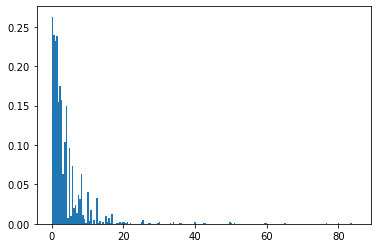

In [57]:
plt.hist(np.transpose(
            np.array(
                data.groupby(
                    by=['Description']).first(
                ).sort_values(by='UnitPrice', ascending=False)[['UnitPrice']]))[0],
        bins=np.linspace(0, 85, 200), density=True)

Les valeurs sont très concentrées autour de 0. Puis les prix descendent rapidement. Ici, on observe clairement une exponentielle.

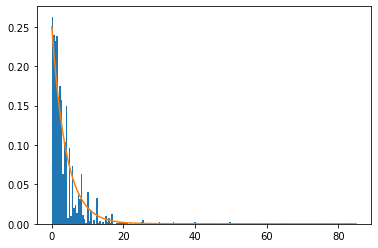

In [58]:
fig, ax=plt.subplots()

ax.hist(np.transpose(
            np.array(
                data.groupby(
                    by=['Description']).first(
                ).sort_values(by='UnitPrice', ascending=False)[['UnitPrice']]))[0],
        bins=np.linspace(0, 85, 200), density=True)

def f(x, l):
    return l*np.exp(-l*x)

ax.plot(np.linspace(0, 85, 200), f(np.linspace(0, 85, 200), 0.25))

### Transactions par pays

In [60]:
data.groupby(by='Country').count().sort_values(by='CustomerID', ascending=False)[['CustomerID']]

,CustomerID
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


Parmis toutes les transactions, une très très grande majorité vient du Royaume-Uni. Même si ce dernier n'était pas présent dans les pays qui dépensent le plus, il est clairement le leader des transactions. Inversement, le pays où les ventes sont très minimes est l'Arabie Saoudite avec uniquement 10 ventes.

In [61]:
labels = np.array(data.groupby(
    by='Country').count().sort_values(by='CustomerID', ascending=False)[['CustomerID']].index)[:4].tolist()

labels.append('Others')

In [62]:
x = np.array(
    data.groupby(by='Country').count().sort_values(by='CustomerID', ascending=False)['CustomerID'])[:4].tolist()

x.append(np.sum(np.array(
    data.groupby(by='Country').count().sort_values(by='CustomerID', ascending=False)['CustomerID'])[4:]))

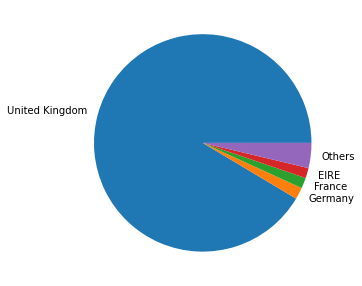

In [63]:
fig = plt.figure(figsize = (10, 5))
plt.pie(x, labels=labels)
plt.show()

Dans ce camembert, on observe clairement la domination du Royaume-Uni. L'Allemagne et la France les suivent.  

### Répartition des produits selon les pays

In [128]:
dictionnaire = {}
for country in np.unique(data['Country']):
    liste = np.unique(np.array(data[data['Country']==country]["ProductCategory"]), return_counts=True)[1]
    liste = liste.tolist()
    for i in range(n_clusters+1):
        if i not in np.unique(np.array(data[data['Country']==country]["ProductCategory"]), return_counts=True)[0]:
            liste.insert(i, 0)
    dictionnaire[country] = liste

<Figure size 720x360 with 0 Axes>

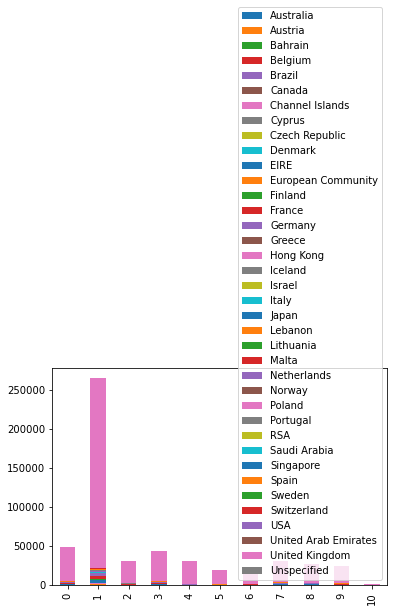

In [129]:
fig = plt.figure(figsize = (10, 5))
pd.DataFrame(dictionnaire, index=range(n_clusters+1)).plot.bar(stacked=True)
plt.show()

Dans cette visualisation, on voit que le Royaume-Uni prend une place très importante. Ainsi, on va traiter ce pays à part et faire de nouveau la procédure ci-dessus pour les autres pays.

In [130]:
countries = np.unique(data['Country']).tolist()
countries.remove('United Kingdom')

dictionnaire = {}
for country in countries:
    liste = np.unique(np.array(data[data['Country']==country]["ProductCategory"]), return_counts=True)[1]
    liste = liste.tolist()
    for i in range(11):
        if i not in np.unique(np.array(data[data['Country']==country]["ProductCategory"]), return_counts=True)[0]:
            liste.insert(i, 0)
    dictionnaire[country] = liste

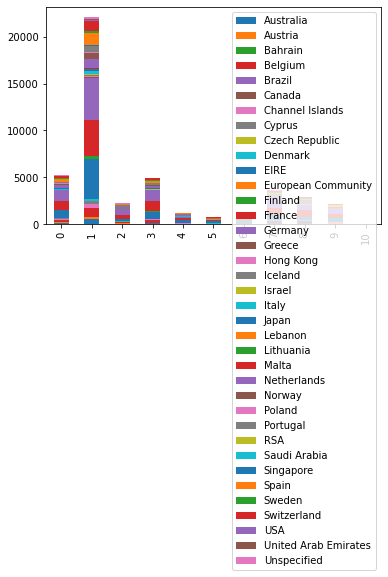

In [131]:
pd.DataFrame(dictionnaire, index=range(11)).plot.bar(stacked=True)
plt.legend(loc='upper right')

Dans ce barplot, on observe la distribution des catégories selon les pays. On retrouve les pays comme la France ou l'Allemagne ainsi que les Pays-Bas.

In [134]:
# Les produits les plus vendus par pays

for country in np.unique(data['Country']):
    print(country, ':', data[data['Country']==country].groupby(
        by=['Description']).sum().sort_values(
            by='Quantity', ascending=False)[['Quantity']].index[0])

Australia : MINI PAINT SET VINTAGE
Austria : SET 12 KIDS COLOUR CHALK STICKS
Bahrain : ICE CREAM SUNDAE LIP GLOSS
Belgium : PACK OF 72 RETROSPOT CAKE CASES
Brazil : ROSES REGENCY TEACUP AND SAUCER
Canada : RETRO COFFEE MUGS ASSORTED
Channel Islands : RAIN PONCHO
Cyprus : HEART DECORATION PAINTED ZINC
Czech Republic : WOODEN TREE CHRISTMAS SCANDINAVIAN
Denmark : RED HARMONICA IN BOX
EIRE : PACK OF 72 RETROSPOT CAKE CASES
European Community : WHITE ROCKING HORSE HAND PAINTED
Finland : CHILDRENS CUTLERY POLKADOT PINK
France : RABBIT NIGHT LIGHT
Germany : ROUND SNACK BOXES SET OF4 WOODLAND
Greece : 4 LAVENDER BOTANICAL DINNER CANDLES
Hong Kong : ROUND SNACK BOXES SET OF4 WOODLAND
Iceland : ICE CREAM SUNDAE LIP GLOSS
Israel : WOODLAND CHARLOTTE BAG
Italy : FEATHER PEN HOT PINK
Japan : RABBIT NIGHT LIGHT
Lebanon : ASSTD FRUIT FLOWERS FRIDGE MAGNETS
Lithuania : FELTCRAFT DOLL ROSIE
Malta : GRAND CHOCOLATECANDLE
Netherlands : RABBIT NIGHT LIGHT
Norway : SMALL FOLDING SCISSOR(POINTED EDGE)
Pola

In [132]:
x = np.unique(np.array(data[data['Country']=='United Kingdom']["ProductCategory"]), return_counts=True)[1]
labels = np.unique(np.array(data[data['Country']=='United Kingdom']["ProductCategory"]), return_counts=True)[0]

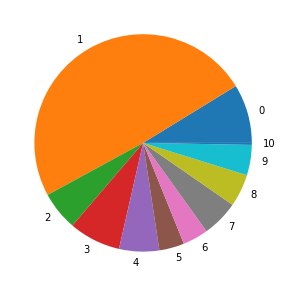

In [133]:
fig = plt.figure(figsize = (10, 5))
plt.pie(x, labels=labels)
plt.show()

Dans ce camembert, on observe une domination des objets en général ainsi qu'un équilibre entre les catégories restantes.